In [1]:
import pandas as pd
import torch
import numpy as np

In [2]:
# Loss function: MSE
def loss_fn(target: torch.Tensor, network_output: torch.Tensor) -> torch.Tensor:
    return torch.mean(torch.square(target - network_output))

In [3]:
import sys
sys.path.append('..')

from utilities import linear_net

In [4]:
training_path = '../training_data/'
verification_path = '../verification_data/'
results_path = '../results/'
interpolating_for = 'exp_inv'

# Interpolating experiment

1. Plot target function and $\mathcal{NN}$ once training has concluded.
2. Represent the training process to visualize convergence.

In [5]:
verification_data = pd.read_csv(f"{verification_path}verification_{interpolating_for}_linspace_{1000}.csv")
xx = torch.tensor(verification_data['x'], dtype = torch.float32)[:, None]

In [6]:
n_inputs = [3, 5, 10, 15, 50, 100, 150]
dimensions = [2, 3, 4, 5, 10, 15, 1000]
learning_rates = [-1, -2, -3]

In [8]:
for dim in [5, 10, 15, 1000]:
    print(f'dim: {dim}')
    for lr_exp in learning_rates:
        print(f'lr {lr_exp}')
        for N in n_inputs:
            print(f'N {N}')
            # Load data
            input_data = pd.read_csv(f"{training_path}/input_{interpolating_for}_linspace_{N}.csv")
            x = torch.tensor(input_data['x'], dtype = torch.float32, requires_grad=False)[:, None]
            target = torch.tensor(input_data['y'], dtype = torch.float32, requires_grad=False)[:, None]

            for use_sigmoid in [True]:#[True, False]:
                # Get net
                NN = linear_net.Net(dim, torch.nn.Sigmoid()) if use_sigmoid \
                    else linear_net.Net(dim, torch.nn.ReLU(0.2))

                # Get optimizer
                optimizer = torch.optim.Adam(NN.parameters(), lr=1**lr_exp)

                # Training phase
                it_counter = 0
                while True:
                    optimizer.zero_grad()
                    loss = loss_fn(target, NN(x))
                    if loss < 1e-2 or it_counter > 10000:
                        network_output = np.reshape(NN(xx).detach().numpy(), newshape=-1)
                        net_type = 'sigmoid' if use_sigmoid else 'relu'
                        pd.DataFrame(data = { 'x': verification_data['x'], 
                                            'y_target': verification_data['y'], 
                                            'y_nn': network_output})\
                                    .to_csv(f'{results_path}/training_performance_{interpolating_for}_input{N}_{net_type}_lr{lr_exp}_dim{dim}.csv',
                                            index=False)
                        break
                    else:
                        loss.backward()
                        optimizer.step()
                        it_counter = it_counter + 1
                        print(f'it {it_counter}: {loss.item()}')

dim: 3
lr -1
N 3
it 1: 0.3983692228794098
it 2: 2.106485605239868
it 3: 0.6261278390884399
it 4: 0.1857117861509323
it 5: 0.49622806906700134
it 6: 0.755204439163208
it 7: 0.6389629244804382
it 8: 0.359269380569458
it 9: 0.18373461067676544
it 10: 0.21708393096923828
it 11: 0.36493122577667236
it 12: 0.4539896249771118
it 13: 0.4053196609020233
it 14: 0.2727513015270233
it 15: 0.161696195602417
it 16: 0.13969194889068604
it 17: 0.19334594905376434
it 18: 0.2506771385669708
it 19: 0.24218249320983887
it 20: 0.14926311373710632
it 21: 0.045323777943849564
it 22: 0.016924792900681496
it 23: 0.04392342269420624
it 24: 0.056564148515462875
it 25: 0.09112292528152466
it 26: 0.12285620719194412
it 27: 0.08189037442207336
it 28: 0.0642348900437355
it 29: 0.0328822135925293
N 5
it 1: 0.4641532003879547
it 2: 7.1174726486206055
it 3: 0.46156787872314453
it 4: 0.7762286067008972
it 5: 1.4374139308929443
it 6: 1.3592725992202759
it 7: 0.9703172445297241
it 8: 0.5287889838218689
it 9: 0.23053398728

it 2: 11.946340560913086
it 3: 0.07608234882354736
it 4: 0.8802833557128906
it 5: 1.6847476959228516
it 6: 1.800675392150879
it 7: 1.4315451383590698
it 8: 0.8891432881355286
it 9: 0.4226931035518646
it 10: 0.17027337849140167
it 11: 0.1554480344057083
it 12: 0.30742740631103516
it 13: 0.505867600440979
it 14: 0.6394841074943542
it 15: 0.6507533192634583
it 16: 0.5468358397483826
it 17: 0.3809083104133606
it 18: 0.22108511626720428
it 19: 0.12157943099737167
it 20: 0.10433785617351532
it 21: 0.15515613555908203
it 22: 0.23449432849884033
it 23: 0.29777902364730835
it 24: 0.3153223693370819
it 25: 0.28263312578201294
it 26: 0.21798694133758545
it 27: 0.15073636174201965
it 28: 0.10696457326412201
it 29: 0.09870226681232452
it 30: 0.12062810361385345
it 31: 0.15487322211265564
it 32: 0.18098320066928864
it 33: 0.18579265475273132
it 34: 0.1684616506099701
it 35: 0.13893108069896698
it 36: 0.11152748763561249
it 37: 0.09744825959205627
it 38: 0.0998087227344513
it 39: 0.11328574270009995


Evaluate accuracy of the algorithm according to dimensionality, learning rate and number of inputs:

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create empty table
shape = (len(learning_rates), len(n_inputs), len(dimensions))
results = np.zeros(shape)

for l_index in range(len(learning_rates)):
    for n_index in range(len(n_inputs)):
        for d_index in range(len(dimensions)):
            n = n_inputs[n_index]
            d = dimensions[d_index]
            l = learning_rates[l_index]

            # Read csv file
            file_name = f"{results_path}training_performance_{interpolating_for}_input{n}_sigmoid_lr{l}_dim{d}.csv"
            df = pd.read_csv(file_name)

            # Do the computations we need
            subtraction = df['y_nn'] - df['y_target']
            size = len(subtraction)
            results[l_index, n_index, d_index] = ((subtraction ** 2).sum() / size) ** 0.5

FileNotFoundError: [Errno 2] No such file or directory: '../results/training_performance_exp_inv_input50_sigmoid_lr-1_dim5.csv'

Plot accuracy and error:

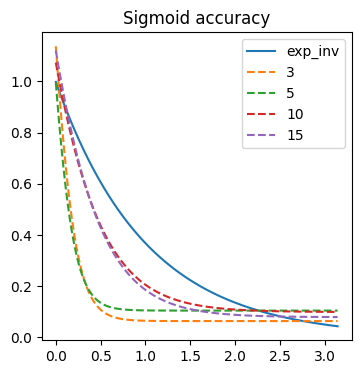

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
plt.plot(verification_data['x'], verification_data['y'], label = interpolating_for)
file_path = f'training_performance_{interpolating_for}_input'
for N in n_inputs:
    df = pd.read_csv(f'{results_path}{file_path}{N}_sigmoid_lr-1_dim2.csv')
    plt.plot(df['x'], df['y_nn'], label = N, linestyle='--')
plt.legend()
plt.title('Sigmoid accuracy')
plt.show()

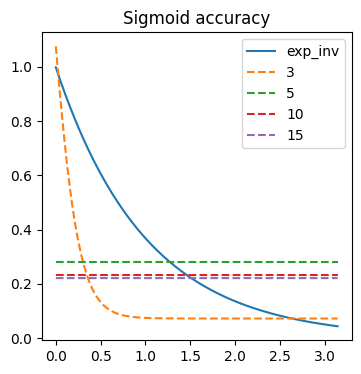

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
plt.plot(verification_data['x'], verification_data['y'], label = interpolating_for)
file_path = f'training_performance_{interpolating_for}_input'
for N in n_inputs:
    df = pd.read_csv(f'{results_path}{file_path}{N}_sigmoid_lr-1_dim15.csv')
    plt.plot(df['x'], df['y_nn'], label = N, linestyle='--')
plt.legend()
plt.title('Sigmoid accuracy')
plt.show()

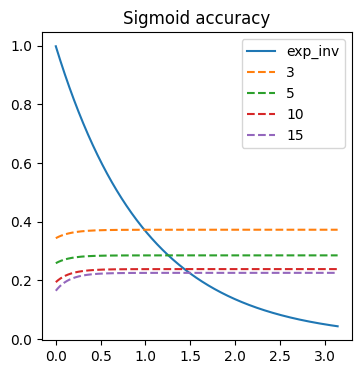

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
plt.plot(verification_data['x'], verification_data['y'], label = interpolating_for)
file_path = f'training_performance_{interpolating_for}_input'
for N in n_inputs:
    df = pd.read_csv(f'{results_path}{file_path}{N}_sigmoid_lr-3_dim1000.csv')
    plt.plot(df['x'], df['y_nn'], label = N, linestyle='--')
plt.legend()
plt.title('Sigmoid accuracy')
plt.show()

# Show results

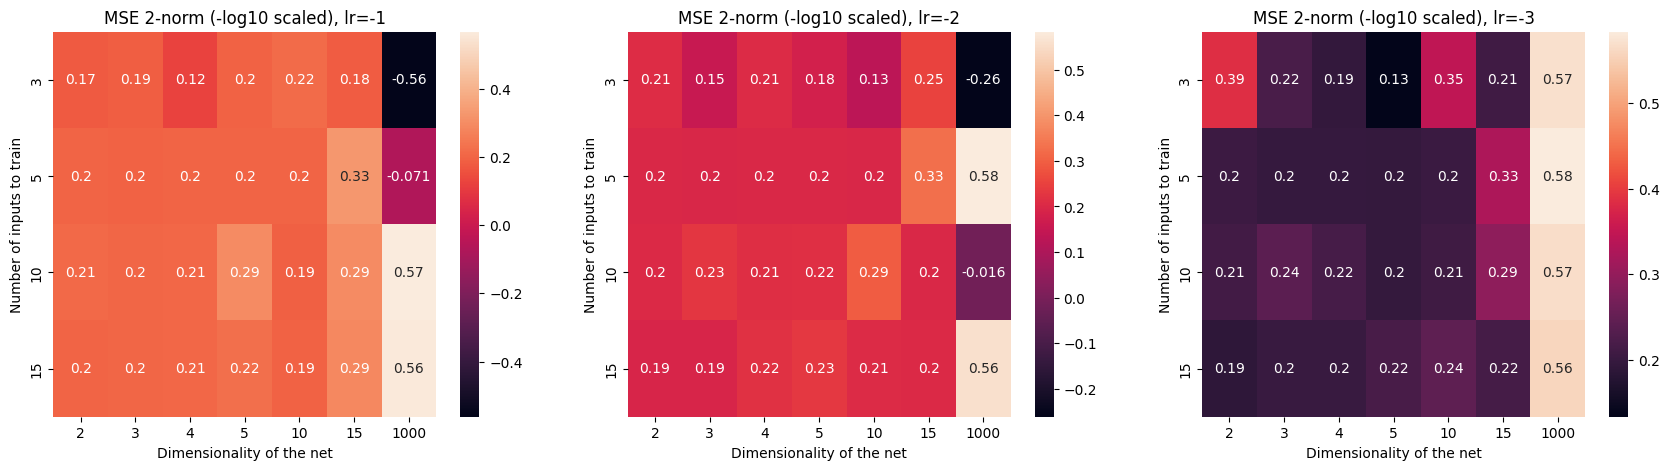

In [29]:
import seaborn
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (21, 5))
for ax_index in range(len(axes)):
    axes[ax_index].set_title(f'MSE 2-norm (-log10 scaled), lr={-(ax_index+1)}')

# x axis: dimension
# y axis: number of inputs

for idx in range(len(learning_rates)):
    input_data_sigmoid = -np.log10(results[idx]).reshape(len(n_inputs), len(dimensions))
    s = seaborn.heatmap(data = input_data_sigmoid, annot = input_data_sigmoid, 
                ax = axes[idx], xticklabels = dimensions, yticklabels = n_inputs)
    s.set(ylabel='Number of inputs to train', xlabel='Dimensionality of the net')